In [26]:
%%bash
# Download TF checkpoints in data/models folder

wget http://download.tensorflow.org/models/adv_inception_v3_2017_08_18.tar.gz
tar -xvzf adv_inception_v3_2017_08_18.tar.gz -C ../DeepExplain/examples/data/models/
rm adv_inception_v3_2017_08_18.tar.gz

adv_inception_v3.ckpt.data-00000-of-00001
adv_inception_v3.ckpt.index
adv_inception_v3.ckpt.meta


--2018-04-03 00:46:25--  http://download.tensorflow.org/models/adv_inception_v3_2017_08_18.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.24.128, 2607:f8b0:400a:809::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.24.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100978389 (96M) [application/x-tar]
Saving to: ‘adv_inception_v3_2017_08_18.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  141K 11m37s
    50K .......... .......... .......... .......... ..........  0%  329K 8m18s
   100K .......... .......... .......... .......... ..........  0%  521K 6m35s
   150K .......... .......... .......... .......... ..........  0%  620K 5m36s
   200K .......... .......... .......... .......... ..........  0% 1.00M 4m48s
   250K .......... .......... .......... .......... ..........  0% 1.14M 4m14s
   300K .......... .......... .......... .......... ..........  0% 1.31M 3m48s
   350K .

In [6]:
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
slim = tf.contrib.slim

In [7]:
# read the labels as a dictionary
import json

json_data = """{
  "0": "tench, Tinca tinca",
  "1": "goldfish, Carassius auratus",
  "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
  "3": "tiger shark, Galeocerdo cuvieri",
  "4": "hammerhead, hammerhead shark",
  "5": "electric ray, crampfish, numbfish, torpedo",
  "6": "stingray",
  "7": "cock",
  "8": "hen",
  "9": "ostrich, Struthio camelus",
  "10": "brambling, Fringilla montifringilla",
  "11": "goldfinch, Carduelis carduelis",
  "12": "house finch, linnet, Carpodacus mexicanus",
  "13": "junco, snowbird",
  "14": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
  "15": "robin, American robin, Turdus migratorius",
  "16": "bulbul",
  "17": "jay",
  "18": "magpie",
  "19": "chickadee",
  "20": "water ouzel, dipper",
  "21": "kite",
  "22": "bald eagle, American eagle, Haliaeetus leucocephalus",
  "23": "vulture",
  "24": "great grey owl, great gray owl, Strix nebulosa",
  "25": "European fire salamander, Salamandra salamandra",
  "26": "common newt, Triturus vulgaris",
  "27": "eft",
  "28": "spotted salamander, Ambystoma maculatum",
  "29": "axolotl, mud puppy, Ambystoma mexicanum",
  "30": "bullfrog, Rana catesbeiana",
  "31": "tree frog, tree-frog",
  "32": "tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui",
  "33": "loggerhead, loggerhead turtle, Caretta caretta",
  "34": "leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea",
  "35": "mud turtle",
  "36": "terrapin",
  "37": "box turtle, box tortoise",
  "38": "banded gecko",
  "39": "common iguana, iguana, Iguana iguana",
  "40": "American chameleon, anole, Anolis carolinensis",
  "41": "whiptail, whiptail lizard",
  "42": "agama",
  "43": "frilled lizard, Chlamydosaurus kingi",
  "44": "alligator lizard",
  "45": "Gila monster, Heloderma suspectum",
  "46": "green lizard, Lacerta viridis",
  "47": "African chameleon, Chamaeleo chamaeleon",
  "48": "Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis",
  "49": "African crocodile, Nile crocodile, Crocodylus niloticus",
  "50": "American alligator, Alligator mississipiensis",
  "51": "triceratops",
  "52": "thunder snake, worm snake, Carphophis amoenus",
  "53": "ringneck snake, ring-necked snake, ring snake",
  "54": "hognose snake, puff adder, sand viper",
  "55": "green snake, grass snake",
  "422": "barbell",
  "423": "barber chair",
  "424": "barbershop"
}"""

labels_dict = json.loads(json_data)

In [10]:
import os
import numpy as np
from scipy.misc import imread
def load_images():
    images = np.zeros((4, 299, 299, 3))
    filenames = []
    idx = 0
    for filepath in tf.gfile.Glob(os.path.join('../DeepExplain/examples/data/images', '*.png')):
        with tf.gfile.Open(filepath,'rb') as f:
            image = imread(f, mode='RGB').astype(np.float) / 255.0
        # Images for inception classifier are normalized to be in [-1, 1] interval.
        images[idx, :, :, :] = image * 2.0 - 1.0
        filenames.append(os.path.basename(filepath))
        idx += 1
    return filenames, images

In [11]:
r, u = load_images()
print(u[0].shape)

(299, 299, 3)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


In [12]:
import skimage
import skimage.io
from skimage.transform import resize
def load_image(path):
    # load image
    img = skimage.io.imread(path)
    img = img / 255.0
    assert (0 <= img).all() and (img <= 1.0).all()
    # print "Original Image Shape: ", img.shape
    # we crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    # resize to 224, 224
    resized_img = skimage.transform.resize(crop_img, (299, 299))
    return resized_img

In [13]:
resized_img = load_image('../DeepExplain/examples/data/images/barbell_1.jpg')
input_resized_img = resized_img.reshape((1, 299, 299, 3))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


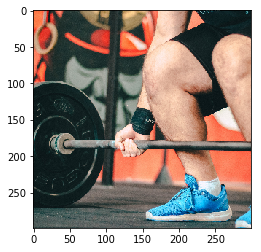

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(resized_img)

In [15]:
# Load Inception V3 model from Tensorflow Slim, restore section
# from checkpoint and run the classifier on the input data
num_classes = 1001

# Select the model here. Use adv_inception_v3 to use the weights of
# an adversarially trained Inception V3. Explanations will be more sparse.

checkpoint = '../DeepExplain/examples/data/models/inception_v3.ckpt'

In [16]:
import pandas as pd
import numpy as np
from sklearn import metrics

In [17]:
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter

In [18]:
tf.reset_default_graph()
sess = tf.Session()

In [19]:
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    yi = tf.argmax(logits, 1)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    #filenames, xs = load_images()
    xs = input_resized_img
    labels = sess.run(yi, feed_dict={X: xs})
    print(labels)

INFO:tensorflow:Restoring parameters from ../DeepExplain/examples/data/models/inception_v3.ckpt
[423]


In [20]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, xs),
    }
    print ("Done!")

2018-04-03 02:46:57,866 - skater.core.local_interpretation.dnni.deep_interpreter - INFO - all supported relevancy scorers OrderedDict([('elrp', <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>)])
2018-04-03 02:46:57,867 - skater.core.local_interpretation.dnni.deep_interpreter - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>


Done!


In [21]:
from skimage import feature, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot(data, xi=None, cmap='bwr', axis=plt, percentile=100, dilation=3.0, alpha=0.8):
    dx, dy = 0.01, 0.01
    print(data.shape[1])
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max
    
    if len(data.shape) == 3:
        print('here')
        data = data[:, :, 0]
    axis.imshow(data, extent=extent, interpolation='nearest', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='nearest', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis

<class 'matplotlib.axes._subplots.AxesSubplot'>
299
here


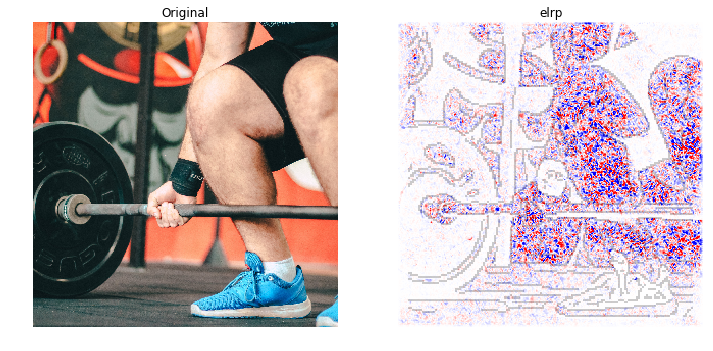

In [22]:
# Plot attributions
%matplotlib inline


input_imgs = [xs[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_imgs) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(input_imgs):
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        print(type(axj))
        plot(relevancy_scores[r_type][i], xi = xi, axis=axj, dilation=.5, percentile=99, alpha=.2).set_title(r_type)